In [ ]:
pip install keras
#High level API of Tensorflow. The core data structures of Keras are layers and models

In [ ]:
pip install tensorflow

In [ ]:
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 32

In [ ]:
import tensorflow as tf
#tf.data API for input pipeline

data_set = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Skin Oiliness Detection with 4 Classes/DataSet",
    shuffle = True,
    image_size = (IMAGE_SIZE),
    #images will be resized to 224x224 pixels.
    batch_size = BATCH_SIZE
)

Found 1343 files belonging to 4 classes.


In [ ]:
len(data_set)
#42 batches with 32 data sets

42

In [ ]:
class_names = data_set.class_names
class_names

['Acne Skin', 'Dry Skin', 'Normal Skin', 'Oily Skin']

In [ ]:
from glob import glob

folders = glob('/content/drive/MyDrive/Skin Oiliness Detection with 4 Classes/DataSet/*')
folders

['/content/drive/MyDrive/Skin Oiliness Detection with 4 Classes/DataSet/Acne Skin',
 '/content/drive/MyDrive/Skin Oiliness Detection with 4 Classes/DataSet/Normal Skin',
 '/content/drive/MyDrive/Skin Oiliness Detection with 4 Classes/DataSet/Dry Skin',
 '/content/drive/MyDrive/Skin Oiliness Detection with 4 Classes/DataSet/Oily Skin']

In [ ]:
# Split the Dataset into training, validation, and test sets

def get_dataset_partitions_tf(ds, train_split=0.8, validation_split=0.1, test_split=0.1, shuffle=True, shuffle_size = 10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size , seed= 12)

    train_size      = int(train_split * ds_size)
    validation_size = int(validation_split * ds_size)

    train_ds = ds.take(train_size)

    validation_ds = ds.skip(train_size).take(validation_size)
    test_ds = ds.skip(train_size).skip(validation_size)

    return train_ds, validation_ds, test_ds

In [ ]:
train_ds, validation_ds, test_ds = get_dataset_partitions_tf(data_set)

In [ ]:
# Creating an instance of vgg16 model using keras
# Model will be initialized with pre-trained weights on the 'ImageNet' dataset
from keras.applications.vgg16 import VGG16

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False) # own input

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Stop the train existing weights of the VGG16 model and preserving the pre-trained features learned from the ImageNet dataset.
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
# We can add Additional layers on the pre-trained vgg16 model

from keras.layers import Input, Lambda, Dense, Flatten, Dropout

x = Flatten()(vgg.output)
x = Dense(1024, activation='relu')(x)   # These 1024 layers are adjusting their weights
# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
prediction = Dense(len(folders), activation='softmax')(x)   # softmax - Interpret the model's output as probabilities

In [ ]:
# Create a Model object by keras

from keras.models import Model

model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# model.compile(
#   loss='categorical_crossentropy',
#   optimizer='adam',
#   metrics=['accuracy']
# )

from keras.optimizers import Adam


learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Loss Function
# Evaluation Metric
# 'categorical crossentropy', which is commonly used for multi-class classification problems where the output labels are one-hot encoded.
# Use 'sparse_categorical_rossentropy' when output labels are ine hot encoded

In [ ]:
import os
import shutil

# Define a function to save the dataset to disk
def save_dataset_to_disk(dataset, directory, class_names):
    for i, (image, label) in enumerate(dataset):
        for j in range(len(image)):
            # Get the class name corresponding to the label
            class_name = class_names[label[j].numpy()]
            # Create class directories if not exist
            class_directory = os.path.join(directory, class_name)
            os.makedirs(class_directory, exist_ok=True)
            # Save images to class directories
            filename = os.path.join(class_directory, f"image_{i * 32 + j}.jpg")
            tf.keras.preprocessing.image.save_img(filename, image[j].numpy())

In [ ]:
save_dataset_to_disk(train_ds, '/content/drive/MyDrive/Skin Oiliness Detection with 4 Classes/Splitted Images/Train',class_names)

In [ ]:
save_dataset_to_disk(test_ds, '/content/drive/MyDrive/Skin Oiliness Detection with 4 Classes/Splitted Images/Test',class_names)

In [ ]:
save_dataset_to_disk(validation_ds, '/content/drive/MyDrive/Skin Oiliness Detection with 4 Classes/Splitted Images/Validation',class_names)

In [ ]:
# Data Augmentation

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,        # Randomly rotate images by 0 to 40 degrees.
    width_shift_range=0.2,    # shift images horizontally by 20% of the width.
    height_shift_range=0.2,   # shift images vertically by 20% of the height.
    shear_range=0.2,          # apply shearing transformations.
    zoom_range=0.2,           # zoom into images.
    horizontal_flip=True,     # flip images horizontally.
    fill_mode='nearest'       # fills in newly created pixels using the nearest pixel value.
)

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Rescales the pixel values[0,255] of the images to the range [0,1]

In [ ]:
training_set = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Skin Oiliness Detection with 4 Classes/Splitted Images/Train',
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode='categorical'      # labels for the images are represented using one-hot encoding
)

Found 1056 images belonging to 4 classes.


In [ ]:
testing_set = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Skin Oiliness Detection with 4 Classes/Splitted Images/Test',
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode='categorical'
)

Found 159 images belonging to 4 classes.


In [ ]:
validation_set = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Skin Oiliness Detection with 4 Classes/Splitted Images/Validation',
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode='categorical'
)

Found 128 images belonging to 4 classes.


In [ ]:
# r - save the histroty of the training process

r = model.fit_generator(
    training_set,
    validation_data=validation_set,
    epochs=25,
    steps_per_epoch=len(training_set),
    validation_steps=len(validation_set)
)

<ipython-input-26-a498570a46e1>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/25
33/33 [==============================] - 21s 604ms/step - loss: 0.7207 - accuracy: 0.7386 - val_loss: 0.6454 - val_accuracy: 0.6875
Epoch 2/25
33/33 [==============================] - 20s 603ms/step - loss: 0.6088 - accuracy: 0.7538 - val_loss: 0.5656 - val_accuracy: 0.7578
Epoch 3/25
33/33 [==============================] - 19s 565ms/step - loss: 0.6235 - accuracy: 0.7576 - val_loss: 0.5696 - val_accuracy: 0.7969
Epoch 4/25
33/33 [==============================] - 20s 598ms/step - loss: 0.5101 - accuracy: 0.8059 - val_loss: 0.5538 - val_accuracy: 0.8047
Epoch 5/25
33/33 [==============================] - 19s 565ms/step - loss: 0.4854 - accuracy: 0.8239 - val_loss: 0.7146 - val_accuracy: 0.7656
Epoch 6/25
33/33 [==============================] - 20s 599ms/step - loss: 0.5774 - accuracy: 0.7983 - val_loss: 0.4554 - val_accuracy: 0.8438
Epoch 7/25
33/33 [==============================] - 18s 560ms/step - loss: 0.4697 - accuracy: 0.8258 - val_loss: 0.5722 - val_accuracy: 0.7969

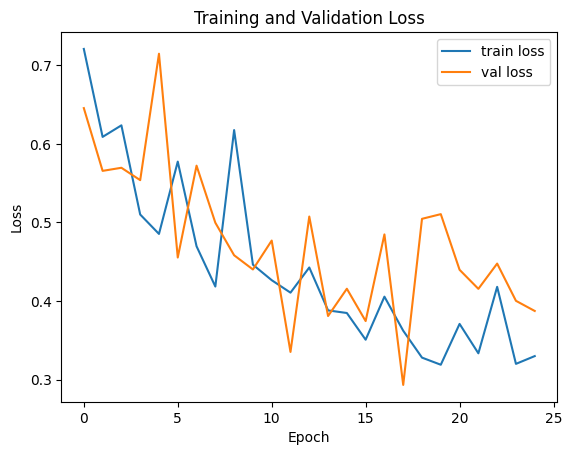

In [ ]:
# Plot training and validation loss

import matplotlib.pyplot as plt

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.savefig('LossVal_loss')  # Save the plot
plt.show()  # Display the plot

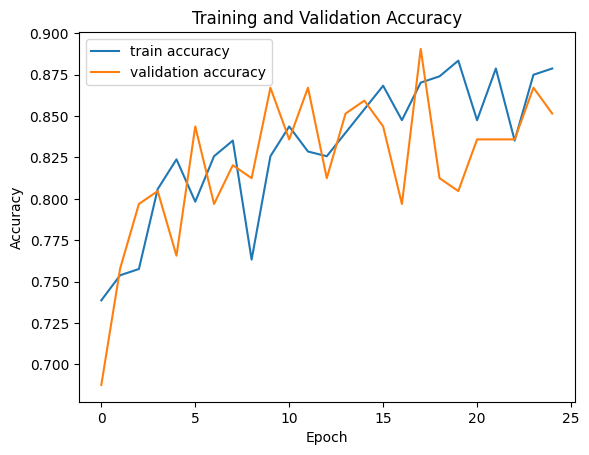

In [ ]:
# Plot training and validation accuracy
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.savefig('AccVal_acc')
plt.show()
# Display the plot

first image to predict
actual label: Acne Skin
1/1 [==============================] - 0s 172ms/step
predicted label: Acne Skin


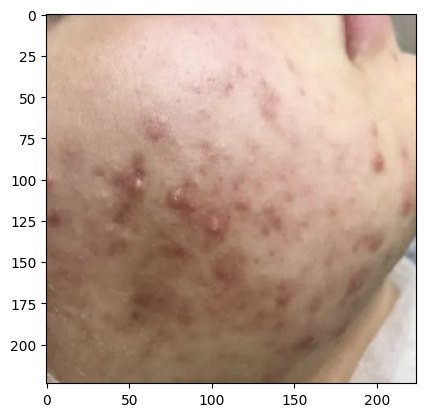

In [ ]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0] .numpy()

    print("first image to predict")
    plt. imshow(first_image)
    print("actual label:", class_names [first_label])

    batch_prediction = model.predict(images_batch)   # probability distributions over the classes
    print("predicted label:" ,class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array (images[i].numpy())
    img_array = tf. expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions [0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 32ms/step


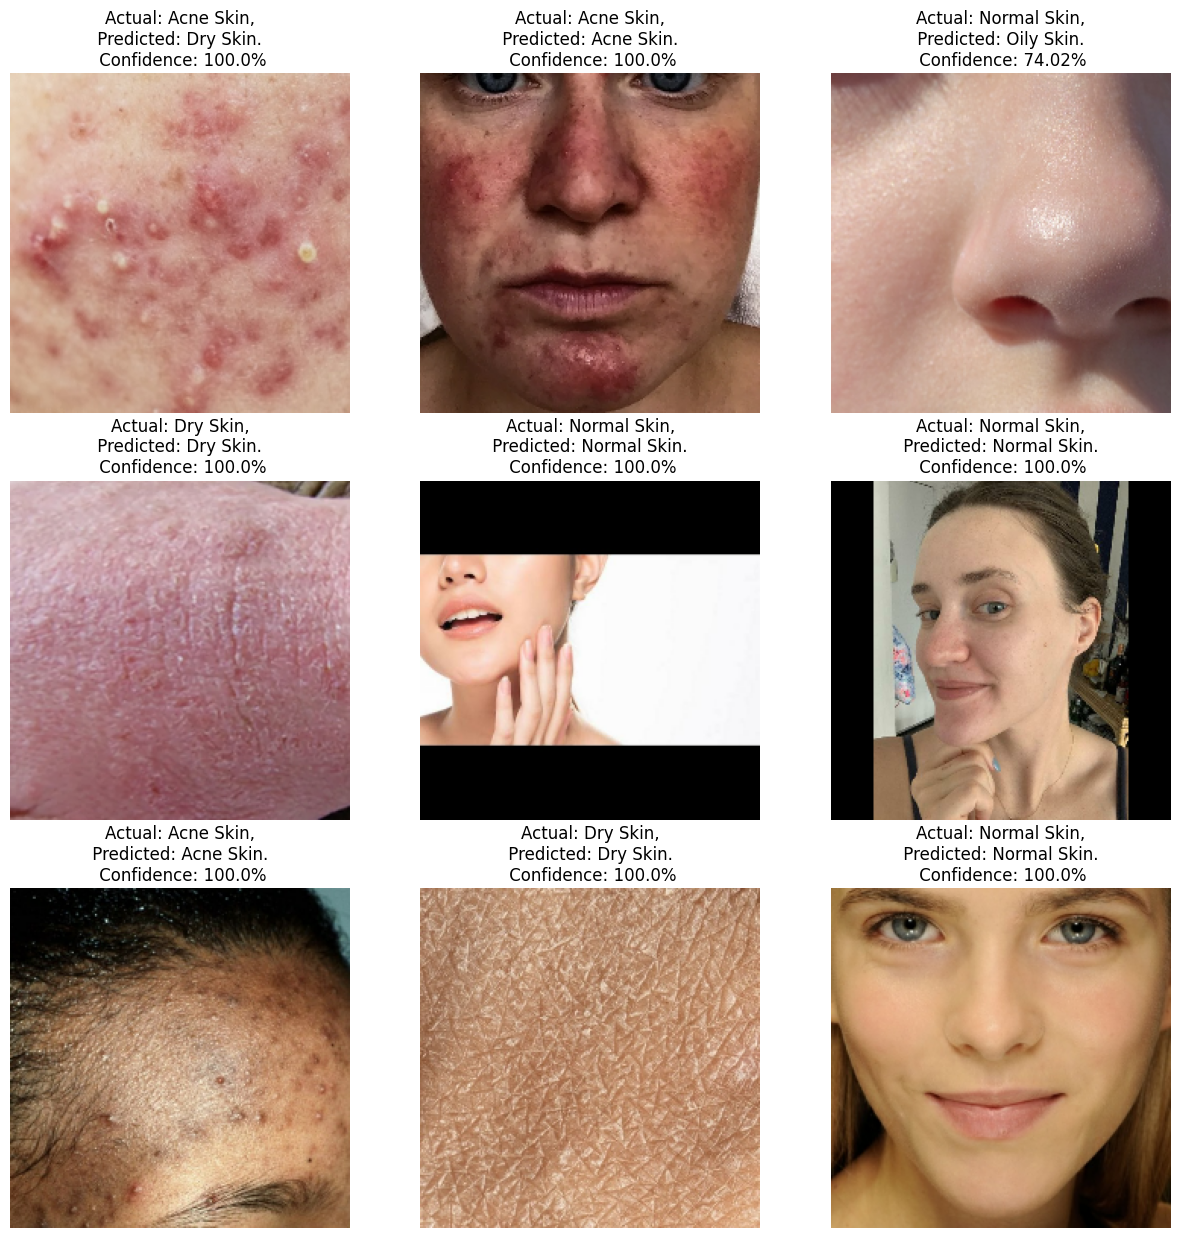

In [ ]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # unsigned integer 8-bit"

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        plt.axis("off")

In [ ]:
model_version = 2
model.save('/content/drive/MyDrive/Skin Oiliness Detection with 4 Classes/Skin Oiliness Detection (Transfer Learning)/Trained Model 3')

In [ ]:
pip install opencv-python


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model



# Load the trained model
model = load_model('/content/drive/MyDrive/Skin Oiliness Detection with 4 Classes/Skin Oiliness Detection (Transfer Learning)/Trained Model')

# Load the face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Access the webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the grayscale frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Extract face ROI
        face_roi = frame[y:y+h, x:x+w]

        # Resize the face ROI to match the input size expected by your model (224x224)
        resized_face = cv2.resize(face_roi, (224, 224))

        # Preprocess the resized face ROI (normalize, etc.)
        # You need to preprocess the face ROI in the same way you preprocessed your training data

        # Make predictions
        prediction = model.predict(np.expand_dims(resized_face, axis=0))
        oiliness_level = np.argmax(prediction)  # Assuming your model outputs class probabilities

        # Display the oiliness level
        cv2.putText(frame, f'Oiliness: {oiliness_level}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Draw a rectangle around the detected face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Display the webcam feed
    cv2.imshow('Webcam Feed', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()
